# Novel Inertia Based Human Pose Estimation Using CNN

In [1]:
#setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
from utils import *

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

Autosaving every 180 seconds


In [ ]:
#Import data from MatLab SimScape Multibody Simulator

#data comes from two files
#1) n trajectories in xyz space, each length m
# traj = np.loadtxt(open("C:/Users/Derm/Desktop/traj_with_angs_1M.txt", "rb"), delimiter=",")
traj = np.loadtxt(open("simulation/data/traj_9DOF_100k.txt", "rb"), delimiter=",")

trajPts = np.shape(traj)[0] #points per trajectory
# numTraj = np.shape(traj)[1]//3 #number of total trajectories
numTraj = np.shape(traj)[1]//6 #number of total trajectories


#traj needs to be reshaped to a 3d numpy array
#as is traj[n] shows [x,y,z,x,y,z...]


#2) 7 joint angles at the end of the sequence
# jointPos = np.loadtxt(open("C:/Users/Derm/Desktop/jointPos_with_angs_1M.txt", "rb"), delimiter=",")
jointPos = np.loadtxt(open("simulation/data/jointPos_9DOF_100k.txt", "rb"), delimiter=",")

# print(traj[-1])
# print(jointPos[0])



In [41]:
#find and fix errors in data 
err = np.argwhere(np.abs(jointPos) == 0)[:,0]
over_extended = np.argwhere(np.abs(jointPos) > 360)

print(err)
print(over_extended)

# Remove cells with errors instead of doubling existing cells
jointPos = np.delete(jointPos,err,axis = 0)
t = np.delete(t,err, axis = 0)

#replace empty trials with data from existing trials
# for i in err[:,0]:
# #     print(jointPos[i])
#     randIndex = int(np.floor(np.random.rand()*np.shape(jointPos)[0]))
#     jointPos[i] = jointPos[randIndex]
#     t[i] = t[randIndex]

print(np.shape(jointPos))
print(np.shape(t))

[]
[]
(247431, 10)
(247431, 10, 6)


In [ ]:
#reshape traj data into 3d numpy array
# t = np.zeros([trajPts,3,numTraj]) #net 1
# for j in range(np.shape(traj)[0]):
#     for i in range(np.shape(traj)[1]//3):
#         t[j,:,i] = traj[j,3*i:3*(i+1)]
        
t = np.zeros([trajPts,6,numTraj]) #net 3
for j in range(np.shape(traj)[0]):
    for i in range(np.shape(traj)[1]//6):
        t[j,:,i] = traj[j,6*i:6*(i+1)]

        
# print(t[:,:,0]) #same as in MatLab
print(np.shape(t))
#swap axis so batch size is first axis (for TF)
t = np.swapaxes(t,0,2)
print(np.shape(t)) #[numTraj, xyz, trajPts]
#swap axis again so that conv1D moves on time and not xyz
t = np.swapaxes(t,1,2)
print(np.shape(t))

In [2]:
#Import and augment data by rotating about y axis

from utils import *

f1 = "simulation/data/traj_9DOF_250k.txt"
f2 = "simulation/data/jointPos_9DOF_250k.txt"
numTraj = 250000
# f1 = "simulation/data/traj_9DOF_test.txt"
# f2 = "simulation/data/jointPos_9DOF_test.txt"
# numTraj = 10000

t, jointPos = add_body_rotation(f1, f2, numTraj, mult = 1)

# print(jointPos[0])

saved augmented data as tbr, jbr


In [4]:
from network import Net4 #for 10DOF model

np.random.seed(1337)

#convert data from numpy to tensors
x_train = tf.convert_to_tensor(t,np.float32)
y_train = tf.convert_to_tensor(jointPos,np.float32)

# print(tf.shape(x_train))
# print(x_train[0,:,1])

In [10]:
model = Net4()

runLen = 100    

def scheduler(epoch, lr):
#     part1 = 2*runLen//3
#     part2 = 5*runLen//6 #net1

    part1 = runLen//3
    part2 = 2*runLen//3 #net2

    if epoch < part1:
        lr = 0.01
        return lr
    if epoch >= part1 and epoch < part2:
        lr = 0.001
        return lr
    if epoch >= part2:
        lr = 0.0001
        return lr

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
#     loss=tf.keras.losses.MeanAbsoluteError(),
#     metrics=[tf.keras.metrics.MeanSquaredError()],
)

summary = model.summary()
print(summary)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

trace = model.fit(x=x_train, y=y_train, batch_size=128, epochs=runLen, verbose=1, 
                  validation_split=0.1, callbacks = [callback], shuffle=True)


Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10, 6)]      0                                            
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 10, 6)        24          input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 8, 16)        304         batch_normalization_28[0][0]     
__________________________________________________________________________________________________
conv1d_23 (Conv1D)              (None, 8, 16)        784         conv1d_22[0][0]                  
_______________________________________________________________________________________

435/435 [==============================] - 8s 19ms/step - loss: 1750.4471 - val_loss: 1513.8555
Epoch 2/100
435/435 [==============================] - 8s 18ms/step - loss: 1312.4580 - val_loss: 1427.3817
Epoch 3/100
435/435 [==============================] - 8s 18ms/step - loss: 1186.8849 - val_loss: 1535.9408
Epoch 4/100
435/435 [==============================] - 8s 18ms/step - loss: 1234.9965 - val_loss: 2517.3931
Epoch 5/100
435/435 [==============================] - 8s 18ms/step - loss: 1184.1584 - val_loss: 1617.0627
Epoch 6/100
435/435 [==============================] - 8s 18ms/step - loss: 1146.7417 - val_loss: 1155.6835
Epoch 7/100
435/435 [==============================] - 8s 18ms/step - loss: 1059.9944 - val_loss: 1236.6111
Epoch 8/100
435/435 [==============================] - 8s 18ms/step - loss: 1185.5199 - val_loss: 1167.3085
Epoch 9/100
435/435 [==============================] - 8s 18ms/step - loss: 1055.0208 - val_loss: 1050.2545
Epoch 10/100
435/435 [==================

435/435 [==============================] - 8s 18ms/step - loss: 252.3168 - val_loss: 533.4161
Epoch 78/100
435/435 [==============================] - 8s 18ms/step - loss: 251.7366 - val_loss: 533.5525
Epoch 79/100
435/435 [==============================] - 8s 18ms/step - loss: 251.2356 - val_loss: 533.5125
Epoch 80/100
435/435 [==============================] - 8s 18ms/step - loss: 249.7000 - val_loss: 533.6329
Epoch 81/100
435/435 [==============================] - 8s 18ms/step - loss: 250.3022 - val_loss: 534.2224
Epoch 82/100
435/435 [==============================] - 8s 18ms/step - loss: 251.0637 - val_loss: 538.0278
Epoch 83/100
435/435 [==============================] - 8s 18ms/step - loss: 249.6418 - val_loss: 534.2051
Epoch 84/100
435/435 [==============================] - 8s 18ms/step - loss: 249.2554 - val_loss: 536.0193
Epoch 85/100
435/435 [==============================] - 8s 18ms/step - loss: 248.3383 - val_loss: 536.9356
Epoch 86/100
435/435 [============================

Text(0, 0.5, 'loss')

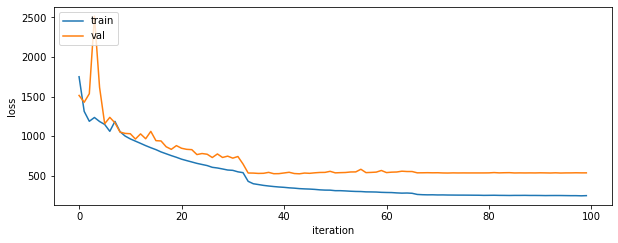

In [11]:
plt.subplot(2, 1, 1)
plt.plot(trace.history['loss'], '-')
plt.plot(trace.history['val_loss'], '-')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('loss')
# plt.ylim(10,1000)

In [12]:
#load larger test dataset (for calculating accuracy of network)

ft1 = "simulation/data/traj_9DOF_1k.txt"
ft2 = "simulation/data/jointPos_9DOF_1k.txt"
numTraj = 1000 #number of trajectories given in base file

tTest, jointPosTest = add_body_rotation(ft1, ft2, numTraj, mult =1)

saved augmented data as tbr, jbr


In [46]:
#load single test case (for use with viz)
#DEBUG -> why does this perform better when data is generated with fast restart disabled??

ft1 = "simulation/data/traj_9DOF_1.txt"
ft2 = "simulation/data/jointPos_9DOF_1.txt"
ft3 = "simulation/data/jointPath.txt"
numTraj = 1 #number of trajectories given in base file

tTest, jointPosTest = add_body_rotation(ft1, ft2, numTraj, mult =1, actual_traj=ft3)

# print(tTest)
# print(jointPosTest) #issue when only one element in jointPos input file

saved augmented data as tbr, jbr, at


In [47]:
#test model- IMPORTANT TO USE NEVER BEFORE SEEN DATA

x_test = tf.convert_to_tensor(tTest,np.float32)
y_test = tf.convert_to_tensor(jointPosTest,np.float32)

prediction = model.predict(x_test)
error = abs(y_test - prediction)

#average error for estimates for each joint
avg = np.average(error,axis=0)
print("average error = ", avg)

#range for each joint:
ranges = [50, 60, 67.5, 110, 120, 360, 130, 180, 110, 360]
rel_error = avg/ranges
print("error as frac of joint range = ", np.floor(rel_error*1000)/1000) #1 is full range of joint
print("total error = ",sum(rel_error))

print("prediction: ",prediction[0])
print("actual: ", y_test[0])

np.save("simulation/data/prediction.npy", prediction)

average error =  [ 4.953479    0.35250598  3.2838852   3.9114075  14.178097    1.0541973
  2.3376884  19.706158   13.399872    8.651581  ]
error as frac of joint range =  [0.099 0.005 0.048 0.035 0.118 0.002 0.017 0.109 0.121 0.024]
total error =  0.5835422678370144
prediction:  [-2.9667887e-01  5.2750403e-01  7.4014664e-02 -6.8090591e+01
  4.4565964e+00 -1.1980803e+01 -5.5135689e+01  4.3908434e+00
 -3.5572128e+01  9.0585571e+01]
actual:  tf.Tensor(
[  4.6568    0.88001   3.3579  -72.002    -9.7215  -13.035   -52.798
  24.097   -48.972    99.23715], shape=(10,), dtype=float32)


Best total error: 

1.52 @ 10k  dataset, mult 1, BS 128, MSE

1.29 @ 100k dataset, mult 2, BS 128, MSE

1.15 @ 100k dataset, mult 1, BS 128, MSE

1.10 @ 100k dataset, mult 1, BS 64,  MSE, Val loss = 851, 10 epoch

0.97 @ 100k dataset, mult 1, BS 128,  MSE, Val loss = 623, 30 epoch

0.86 @ 100k dataset, mult 1, BS 128,  MSE, Val loss = 556, 100 epoch

0.90 @ 250k dataset (replace errors with repeats), mult 1, BS 128, val loss = 476, 100 epoch

currently trying without 512 layers...

Notes:
artifially creating more data by rotating about y axis at different angles is a bad idea. This teaches the network to memorize patterns of movement rather than learn the underlying dynamic models.

In [ ]:
# model.save("10DOF.kmod")

In [ ]:
#load best scoring model

model = tf.keras.models.load_model("10DOF.kmod")

In [ ]:
#proof my model is doing better than completely random guessing

np.random.seed(None)

# print(actual)
# print(tf.shape(actual)) #[99 7]
B = tf.random.uniform([1000,7])

# B = tf.ones([99,7])
B = B *tf.constant([25., 30., 33.75, 55. , 60., 180., 65.]) + tf.constant([0., 0., 26.25, -35., 30., 0., -65.])

# print(tf.shape(B))
# print(tf.shape(actual))

fake_error = (y_test - B)
# print(fake_error)

fake_avg = tf.math.reduce_mean(tf.math.abs(fake_error), axis=0)
print(fake_avg)

rel_fake_error = fake_avg/ranges

print("error as frac of joint range: ",rel_fake_error)
print("total error: ", sum(rel_fake_error))

#NOTE: these are not all the same becuase the starting ranges for joint positions do NOT fall in the middle of all
#      possible positions for each joint

In [ ]:
from scipy.spatial.transform import Rotation as R
r = R.from_euler('zyx', [
[90, 0, 0],
[0, 45, 0],
[45, 60, 30]], degrees=True)

print(r)
r.as_quat()

v = [1, 2, 3]

r.apply(v)

In [ ]:
r1 = R.from_euler('z', 90, degrees=True)
r2 = R.from_euler('x', 90, degrees=True)
r3 = r1*r2

v = [1, 2, 3]

rot1 = r1.apply(v)
rot2 = r3.apply(v)
print(rot2)


In [ ]:
a, b, c= r3.apply([1, 2, 3])
print(a,b,c)
